In [1]:
#@test {"skip": true}

!pip install --quiet --upgrade tensorflow-federated

In [2]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/LAB3-20221109T160610Z-001/LCL-FullData/Cluster8data.csv')

In [5]:
# dividing the two year data into 24 parts (each 1 month data)
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [6]:
# Filter the DataFrame to include readings from Jan 01, 2012, to Dec 31, 2012
start_date1 = pd.to_datetime('2011-10-01')
end_date1 = pd.to_datetime('2013-02-28')
filtered_data1 = data[(data['DateTime'] >= start_date1) & (data['DateTime'] <= end_date1)]

# Filter the DataFrame to include readings from Jan 01, 2013, to Dec 31, 2013
start_date2 = pd.to_datetime('2013-01-01')
end_date2 = pd.to_datetime('2013-12-31')
filtered_data2 = data[(data['DateTime'] >= start_date2) & (data['DateTime'] <= end_date2)]

In [7]:
# Select 5 unique LCLids
lclid_list1 = filtered_data1['LCLid'].unique()
selected_lclids1 = lclid_list1[:20]

# Filter data for the selected LCLids
f_data1 = filtered_data1[filtered_data1['LCLid'].isin(selected_lclids1)]

# Select 5 unique LCLids
lclid_list2 = filtered_data2['LCLid'].unique()
selected_lclids2 = lclid_list2[:20]

# Filter data for the selected LCLids
f_data2 = filtered_data2[filtered_data2['LCLid'].isin(selected_lclids2)]

In [8]:
datan1 = f_data1.copy()
datan1['KWH/hh'] = datan1['KWH/hh'].astype(np.float32)
datan2 = f_data2.copy()
datan2['KWH/hh'] = datan2['KWH/hh'].astype(np.float32)

datan1 = datan1.drop('cluster', axis=1)
datan1 = datan1.drop('stdorToU', axis=1)
datan2 = datan2.drop('cluster', axis=1)
datan2 = datan2.drop('stdorToU', axis=1)

In [9]:
datan1.reset_index(drop=True, inplace=True)
datan2.reset_index(drop=True, inplace=True)

In [10]:
datan1['DateTime'] = pd.to_datetime(datan1.DateTime).dt.tz_localize(None)
for i in range(len(datan1)):
  datan1['DateTime'][i]=datan1['DateTime'][i].timestamp()

<ipython-input-10-b59380e28e58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datan1['DateTime'][i]=datan1['DateTime'][i].timestamp()


In [11]:
datan2['DateTime'] = pd.to_datetime(datan2.DateTime).dt.tz_localize(None)
for i in range(len(datan2)):
  datan2['DateTime'][i]=datan2['DateTime'][i].timestamp()

<ipython-input-11-04c0d2c83489>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datan2['DateTime'][i]=datan2['DateTime'][i].timestamp()


In [12]:
datan1['DateTime'] = datan1['DateTime'].astype(np.float32)
datan2['DateTime'] = datan2['DateTime'].astype(np.float32)

In [13]:
# Sort the data by 'LCLid' and 'DateTime'
datan1.sort_values(['LCLid', 'DateTime'], inplace=True)
datan2.sort_values(['LCLid', 'DateTime'], inplace=True)

In [14]:
# Define the client window dataset function for a specific LCLid
def create_client_dataset_for_LCLid(client_data, window_size, step_size):
    client_windows = []
    client_targets = []
    num_readings = len(client_data)

    # Iterate over the readings using the sliding window
    for i in range(0, num_readings - window_size, step_size):
        window_start = i
        window_end = i + window_size - 1
        prediction_index = window_end + step_size

        # Extract the window and the prediction target
        window = client_data.iloc[window_start:window_end + 1]['KWH/hh'].values
        target = client_data.iloc[prediction_index]['KWH/hh']

        client_windows.append(window)
        client_targets.append(target)

    # Create an ordered dictionary with 'x' and 'y' keys
    ordered_dict = collections.OrderedDict()
    ordered_dict['x'] = tf.stack(client_windows)
    ordered_dict['y'] = tf.expand_dims(client_targets, axis=-1)


    return ordered_dict

In [15]:
window_size = 336
step_size = 1

# Filter the dataframe for the specific LCLid
example_LCLid = datan1['LCLid'].unique()[3]
clientyy_data = datan1[datan1['LCLid'] == example_LCLid]

# Create the client dataset for the specific LCLid
example_client_dataset = create_client_dataset_for_LCLid(clientyy_data, window_size, step_size)

print("Client dataset for LCLid", example_LCLid)
print(example_client_dataset)

Client dataset for LCLid MAC000067
OrderedDict([('x', <tf.Tensor: shape=(21112, 336), dtype=float32, numpy=
array([[0.127, 0.64 , 0.237, ..., 0.135, 0.15 , 0.174],
       [0.64 , 0.237, 0.22 , ..., 0.15 , 0.174, 0.205],
       [0.237, 0.22 , 0.215, ..., 0.174, 0.205, 0.169],
       ...,
       [0.343, 0.303, 0.303, ..., 0.129, 0.12 , 0.133],
       [0.303, 0.303, 0.322, ..., 0.12 , 0.133, 0.117],
       [0.303, 0.322, 0.268, ..., 0.133, 0.117, 0.171]], dtype=float32)>), ('y', <tf.Tensor: shape=(21112, 1), dtype=float32, numpy=
array([[0.205],
       [0.169],
       [0.116],
       ...,
       [0.117],
       [0.171],
       [0.197]], dtype=float32)>)])


In [16]:
NUM_EPOCHS = 5
BATCH_SIZE = 12
SHUFFLE_BUFFER = 60
PREFETCH_BUFFER = 6

def preprocess_client_dataset(dataset):
    def batch_format_fn(element):
        return collections.OrderedDict(
            x=tf.reshape(element['x'], [-1, 336]),
            y=tf.reshape(element['y'], [-1, 1]))
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
        BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)


preprocessed_example_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(example_client_dataset))


sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_client_dataset)))

sample_batch

OrderedDict([('x',
              array([[0.269, 0.285, 0.256, ..., 0.193, 0.383, 0.317],
                     [0.286, 0.224, 0.169, ..., 0.593, 0.488, 0.322],
                     [0.179, 0.161, 0.173, ..., 0.127, 0.124, 0.095],
                     ...,
                     [0.168, 0.126, 0.124, ..., 0.282, 0.24 , 0.211],
                     [0.084, 0.106, 0.104, ..., 0.093, 0.073, 0.088],
                     [0.55 , 0.264, 0.228, ..., 0.238, 0.246, 0.251]], dtype=float32)),
             ('y',
              array([[0.593],
                     [0.29 ],
                     [0.313],
                     [0.395],
                     [0.146],
                     [0.088],
                     [0.235],
                     [0.095],
                     [0.124],
                     [0.199],
                     [0.077],
                     [0.228]], dtype=float32))])

In [17]:
import random

NUM_CLIENTS = 15  # Replace with desired number of clients
all_clients = datan1['LCLid'].unique()
sample_clients = random.sample(all_clients.tolist(), NUM_CLIENTS)

sample_clients_list = sample_clients
sample_clients_list

['MAC000179',
 'MAC000175',
 'MAC000154',
 'MAC000239',
 'MAC000208',
 'MAC000123',
 'MAC000127',
 'MAC000041',
 'MAC000228',
 'MAC000027',
 'MAC000143',
 'MAC000241',
 'MAC000067',
 'MAC000118',
 'MAC000264']

In [18]:
# Iterate over unique LCLids in the dataframe
client_datasets_12 = {}
for LCLid in sample_clients_list:
    # Filter the dataframe for the current LCLid
    client_data = datan1[datan1['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    client_datasets_12[LCLid] = preprocessed_client_dataset

    print("Client dataset for LCLid", LCLid)
    print(sam_batch)

Client dataset for LCLid MAC000179
OrderedDict([('x', array([[0.42 , 0.429, 0.329, ..., 0.057, 0.059, 0.057],
       [0.196, 0.17 , 0.17 , ..., 0.102, 0.056, 0.075],
       [0.19 , 0.162, 0.169, ..., 0.116, 0.123, 0.081],
       ...,
       [0.207, 0.258, 0.195, ..., 0.066, 0.125, 0.087],
       [0.252, 0.249, 0.259, ..., 0.105, 0.093, 0.057],
       [0.165, 0.123, 0.115, ..., 0.093, 0.096, 0.056]], dtype=float32)), ('y', array([[0.056],
       [0.062],
       [0.066],
       [0.096],
       [0.104],
       [0.093],
       [0.129],
       [0.124],
       [0.056],
       [0.074],
       [0.1  ],
       [0.084]], dtype=float32))])
Client dataset for LCLid MAC000175
OrderedDict([('x', array([[0.097, 0.117, 0.12 , ..., 0.085, 0.062, 0.062],
       [0.193, 0.21 , 0.18 , ..., 0.076, 0.095, 0.064],
       [0.204, 0.182, 0.189, ..., 0.221, 0.224, 0.242],
       ...,
       [0.589, 0.4  , 0.599, ..., 0.212, 0.182, 0.23 ],
       [0.116, 0.134, 0.125, ..., 0.061, 0.086, 0.066],
       [0.592, 0.

In [19]:
# Iterate over unique LCLids in the dataframe
client_datasets_13 = {}
for LCLid in sample_clients_list:
    # Filter the dataframe for the current LCLid
    client_data = datan2[datan2['LCLid'] == LCLid]

    clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

    # Create the client dataset for the current LCLid
    preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

    # Extract a sample batch from the preprocessed dataset
    sam_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_client_dataset)))

    # Store the preprocessed dataset in the dictionary with LCLid as the key
    client_datasets_13[LCLid] = preprocessed_client_dataset



In [20]:
def make_federated_data(client_datasets, sample_clients_list):
    return [
        client_datasets[x] for x in sample_clients_list
    ]

In [21]:
federated_train_data_12 = make_federated_data(client_datasets_12, sample_clients)
federated_train_data_13 = make_federated_data(client_datasets_13, sample_clients)

In [22]:
print(f'Number of client datasets: {len(federated_train_data_12)}')
print(f'First dataset: {federated_train_data_12[0]}')
print(f'Second dataset: {federated_train_data_12[1]}')

Number of client datasets: 15
First dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>
Second dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>


In [23]:
preprocessed_example_client_dataset.element_spec

OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)),
             ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])

In [24]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(336,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [25]:
def model_fn():
    keras_model = create_model()
    loss = tf.keras.losses.MeanAbsoluteError()
    tff_model = tff.learning.models.from_keras_model(
        keras_model,
        input_spec=preprocessed_example_client_dataset.element_spec,
        loss=loss,
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return tff_model

In [26]:
model = model_fn()
print(model)

In [27]:
# training starts
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

In [28]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[336,64],
      float32[64],
      float32[64,32],
      float32[32],
      float32[32,8],
      float32[8],
      float32[8,1],
      float32[1]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[336,64],
    float32[64],
    float32[64,32],
    float32[32],
    float32[32,8],
    float32[8],
    float32[8,1],
    float32[1]
  >
>@SERVER)


In [29]:
train_state = training_process.initialize()

In [30]:
federated_train_data_12

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, n

In [31]:
federated_train_data_12

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, n

In [32]:
result = training_process.next(train_state, federated_train_data_12)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.11917885), ('loss', 0.064016044), ('num_examples', 1586220), ('num_batches', 132192)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [33]:
NUM_ROUNDS = 21
for round_num in range(2, NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data_12)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.11332934), ('loss', 0.059329573), ('num_examples', 1586220), ('num_batches', 132192)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.11055082), ('loss', 0.05714846), ('num_examples', 1586220), ('num_batches', 132192)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('root_mean_squared_error', 0.10919152), ('loss', 0.056001242), ('num_examples', 1586220), ('num_batches', 132192)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', (

In [39]:
import plotly.graph_objects as go

# Data for Cluster 08
rounds_1 = list(range(1, 21))
mae_1 = [
    0.06737575, 0.06293772, 0.060796063, 0.05940758, 0.058408998,
    0.057648093, 0.05703, 0.056526024, 0.05610915, 0.055751048,
    0.05542996, 0.055151854, 0.054903667, 0.05467346, 0.05447607,
    0.054296006, 0.054134406, 0.053993754, 0.05387066, 0.053758096
]

# Data for Cluster 09
rounds_2 = list(range(1, 21))
mae_2 = [
    0.07034567, 0.06416719, 0.061836798, 0.060558915, 0.059689056,
    0.059010174, 0.058474753, 0.058048673, 0.057682555, 0.057362556,
    0.057089813, 0.056855284, 0.056644276, 0.056458063, 0.05630099,
    0.056166247, 0.05603734, 0.055925187, 0.05582829, 0.05573636
]

# Creating trace for Cluster 08
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Cluster 08'
)

# Creating trace for Cluster 09
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Cluster 09'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) of Load Forecasting vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='Training data - MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [32]:
import plotly.graph_objects as go

# Data for Cluster 04
rounds_1 = list(range(1, 21))
mae_1 = [
    0.11573566, 0.10361333, 0.09922377, 0.09694171, 0.09549518,
    0.094502784, 0.09377624, 0.09319854, 0.09278589, 0.09244496,
    0.0921646, 0.09189611, 0.09168941, 0.09149853, 0.09130679,
    0.09120082, 0.09106272, 0.09095054, 0.09086295, 0.090747595
]

# Data for Cluster 14
rounds_2 = list(range(1, 21))
mae_2 = [
    0.1708811, 0.1584751, 0.15332645, 0.15120173, 0.14984801,
    0.14892414, 0.14833829, 0.14782089, 0.14744286, 0.14694408,
    0.14646958, 0.14602049, 0.14571527, 0.14540415, 0.14500421,
    0.1446545, 0.14432915, 0.14402962, 0.14367345, 0.14337786
]

# Creating trace for Cluster 04
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Cluster 04'
)

# Creating trace for Cluster 14
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Cluster 14'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) of Load Forecasting vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='Training data - MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [33]:
import plotly.graph_objects as go

# Data for Cluster 07
rounds_1 = list(range(1, 21))
mae_1 = [
    0.24215707, 0.22306563, 0.21767606, 0.21497612, 0.21307865,
    0.21194346, 0.21102037, 0.2100187, 0.20892245, 0.2077742,
    0.20704211, 0.20606637, 0.20509331, 0.20452215, 0.20378909,
    0.20307666, 0.2025013, 0.20195374, 0.20134038, 0.20096558
]

# Data for Cluster 18
rounds_2 = list(range(1, 21))
mae_2 = [
    0.25958988, 0.2282181, 0.21869427, 0.21352097, 0.21052141,
    0.20815776, 0.20585926, 0.2046754, 0.20356816, 0.20232281,
    0.20153011, 0.2007333, 0.20026353, 0.19920154, 0.19846562,
    0.19802547, 0.19739366, 0.19712806, 0.19636787, 0.19576551
]

# Creating trace for Cluster 07
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Cluster 07'
)

# Creating trace for Cluster 18
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Cluster 18'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) of Load Forecasting vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='Training data - MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Data for Cluster - 08, Batch Size = 24, Shuffle Buffer = 120, Prefetch Buffer = 12
rounds_1 = list(range(1, 16))
mae_1 = [
    0.07406851, 0.06911341, 0.06588133, 0.06381104, 0.062328234,
    0.061173238, 0.060279164, 0.059583493, 0.059030402, 0.058575064,
    0.05819059, 0.05786198, 0.05756866, 0.05733508, 0.057126228
]

# Data for Cluster - 08, Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6
rounds_2 = list(range(1, 16))
mae_2 = [
    0.070309095, 0.06450078, 0.061607864, 0.060092628, 0.059076704,
    0.05836942, 0.057809025, 0.057371534, 0.05702302, 0.056733135,
    0.056459244, 0.056229576, 0.056033693, 0.055863913, 0.055711426
]

# Creating trace for Cluster - 08, Batch Size = 24, Shuffle Buffer = 120, Prefetch Buffer = 12
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Batch Size = 24, Shuffle Buffer = 120, Prefetch Buffer = 12'
)

# Creating trace for Cluster - 08, Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) vs. Federated Rounds with Learning Rate - 0.02',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [ ]:
import plotly.graph_objects as go

# Data for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.02
rounds_1 = list(range(1, 16))
mae_1 = [
    0.070309095, 0.06450078, 0.061607864, 0.060092628, 0.059076704,
    0.05836942, 0.057809025, 0.057371534, 0.05702302, 0.056733135,
    0.056459244, 0.056229576, 0.056033693, 0.055863913, 0.055711426
]

# Data for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.01
rounds_2 = list(range(1, 16))
mae_2 = [
    0.06575257, 0.059883647, 0.05776895, 0.056706358, 0.056026068,
    0.055522144, 0.05512807, 0.05480615, 0.054533303, 0.05431394,
    0.054116458, 0.053937282, 0.053791393, 0.05366001, 0.05353039
]

# Creating trace for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.02
trace1 = go.Scatter(
    x=rounds_1,
    y=mae_1,
    mode='lines',
    name='Learning Rate = 0.02'
)

# Creating trace for Batch Size = 12, Shuffle Buffer = 60, Prefetch Buffer = 6, Learning Rate = 0.01
trace2 = go.Scatter(
    x=rounds_2,
    y=mae_2,
    mode='lines',
    name='Learning Rate = 0.01'
)

# Creating data list
data = [trace1, trace2]

# Creating layout
layout = go.Layout(
    title='Mean Absolute Error (MAE) vs. Federated Rounds',
    xaxis=dict(title='Federated Rounds'),
    yaxis=dict(title='MAE')
)

# Creating figure
fig = go.Figure(data=data, layout=layout)

# Displaying the graph
fig.show()


In [34]:
# Filter data for the specified time period
start_date = '2013-03-01'
end_date = '2014-02-28'
filtered_data = data[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)]

# Calculate the average KWH/hh for each LCLid
average_kwh = filtered_data.groupby('LCLid')['KWH/hh'].mean()

# Find the LCLids with the lowest, highest, and medium average KWH/hh
lowest_avg_lclid = average_kwh.idxmin()
highest_avg_lclid = average_kwh.idxmax()
medium_avg_lclid = average_kwh.sort_values().index[len(average_kwh) // 2]

lowest_avg_lclid, highest_avg_lclid, medium_avg_lclid

('MAC000946', 'MAC001715', 'MAC001928')

In [35]:
# Assuming your data is stored in a DataFrame called 'data'
# Calculate the average KWH/hh for each LCLid
average_kwh = filtered_data.groupby('LCLid')['KWH/hh'].mean()

# Print all LCLids with their corresponding average KWH/hh
for lclid, avg_kwh in average_kwh.items():
    print(f"LCLid: {lclid}, Average KWH/hh: {avg_kwh}")

LCLid: MAC000027, Average KWH/hh: 0.17755218584916457
LCLid: MAC000033, Average KWH/hh: 0.15519773494823544
LCLid: MAC000041, Average KWH/hh: 0.18327049136303838
LCLid: MAC000067, Average KWH/hh: 0.12797408911514044
LCLid: MAC000118, Average KWH/hh: 0.17898346965051765
LCLid: MAC000123, Average KWH/hh: 0.15642424935087218
LCLid: MAC000127, Average KWH/hh: 0.1898002173358499
LCLid: MAC000143, Average KWH/hh: 0.18460687526740263
LCLid: MAC000154, Average KWH/hh: 0.13875990872540633
LCLid: MAC000175, Average KWH/hh: 0.16180844248698736
LCLid: MAC000179, Average KWH/hh: 0.11634280810408922
LCLid: MAC000184, Average KWH/hh: 0.19160761172258323
LCLid: MAC000190, Average KWH/hh: 0.138320386689166
LCLid: MAC000208, Average KWH/hh: 0.1918430357255016
LCLid: MAC000214, Average KWH/hh: 0.1620173873312743
LCLid: MAC000219, Average KWH/hh: 0.12781214963962934
LCLid: MAC000228, Average KWH/hh: 0.1295455532971118
LCLid: MAC000239, Average KWH/hh: 0.15234770920894583
LCLid: MAC000244, Average KWH/hh: 

In [ ]:
tdata_lavg = data[data['LCLid'] == lowest_avg_lclid]
tdata_lavg

,LCLid,stdorToU,DateTime,KWH/hh,cluster
7689742,MAC002612,Std,2012-07-10 12:30:00,0.157,8
7689743,MAC002612,Std,2012-07-10 13:00:00,0.112,8
7689744,MAC002612,Std,2012-07-10 13:30:00,0.021,8
7689745,MAC002612,Std,2012-07-10 14:00:00,0.006,8
7689746,MAC002612,Std,2012-07-10 14:30:00,0.022,8
...,...,...,...,...,...
7718435,MAC002612,Std,2014-02-27 22:30:00,0.000,8
7718436,MAC002612,Std,2014-02-27 23:00:00,0.000,8
7718437,MAC002612,Std,2014-02-27 23:30:00,0.000,8
7718438,MAC002612,Std,2014-02-28 00:00:00,0.000,8


In [ ]:
tdata_havg = data[data['LCLid'] == highest_avg_lclid]
tdata_havg

,LCLid,stdorToU,DateTime,KWH/hh,cluster
9135597,MAC003160,Std,2012-07-20 15:30:00,0.237,8
9135598,MAC003160,Std,2012-07-20 16:00:00,0.347,8
9135599,MAC003160,Std,2012-07-20 16:30:00,0.638,8
9135600,MAC003160,Std,2012-07-20 17:00:00,0.339,8
9135601,MAC003160,Std,2012-07-20 17:30:00,0.074,8
...,...,...,...,...,...
9163805,MAC003160,Std,2014-02-27 22:30:00,0.005,8
9163806,MAC003160,Std,2014-02-27 23:00:00,0.006,8
9163807,MAC003160,Std,2014-02-27 23:30:00,0.044,8
9163808,MAC003160,Std,2014-02-28 00:00:00,0.048,8


In [ ]:
tdata_mavg = data[data['LCLid'] == medium_avg_lclid]
tdata_mavg

,LCLid,stdorToU,DateTime,KWH/hh,cluster
4083563,MAC001238,Std,2012-05-14 09:00:00,0.306,8
4083564,MAC001238,Std,2012-05-14 09:30:00,0.103,8
4083565,MAC001238,Std,2012-05-14 10:00:00,0.104,8
4083566,MAC001238,Std,2012-05-14 10:30:00,0.103,8
4083567,MAC001238,Std,2012-05-14 11:00:00,0.101,8
...,...,...,...,...,...
4114902,MAC001238,Std,2014-02-27 22:30:00,0.061,8
4114903,MAC001238,Std,2014-02-27 23:00:00,0.111,8
4114904,MAC001238,Std,2014-02-27 23:30:00,0.068,8
4114905,MAC001238,Std,2014-02-28 00:00:00,0.064,8


In [318]:
filtered_data44 = data[data['LCLid'] == 'MAC001928']

In [358]:
import pandas as pd

# Define the start and end dates for the entire range
start_date = pd.to_datetime('2013-04-07 00:00')
end_date = pd.to_datetime('2013-04-15 00:00')

# Define the time difference between each element in the array
time_difference = pd.DateOffset(minutes=30)

# Initialize an empty list to store the array elements
array = []

# Loop through the range and generate the data for each element
current_date = start_date
for _ in range(48):
    # Define the start and end dates for each element
    element_start_date = current_date
    element_end_date = element_start_date + pd.DateOffset(days=8)

    # Filter the data based on the element's date range
    element_data = filtered_data44[(filtered_data44['DateTime'] >= element_start_date) & (filtered_data44['DateTime'] <= element_end_date)]

    # Append the filtered data to the array
    array.append(element_data)

    # Update the current date for the next element
    current_date += time_difference



In [359]:
array[47]

,LCLid,stdorToU,DateTime,KWH/hh,cluster
11868812,MAC001928,ToU,2013-04-07 23:30:00,0.479,7
11868813,MAC001928,ToU,2013-04-08 00:00:00,0.407,7
11868814,MAC001928,ToU,2013-04-08 00:30:00,0.367,7
11868815,MAC001928,ToU,2013-04-08 01:00:00,0.348,7
11868816,MAC001928,ToU,2013-04-08 01:30:00,0.391,7
...,...,...,...,...,...
11869192,MAC001928,ToU,2013-04-15 21:30:00,0.276,7
11869193,MAC001928,ToU,2013-04-15 22:00:00,0.208,7
11869194,MAC001928,ToU,2013-04-15 22:30:00,0.200,7
11869195,MAC001928,ToU,2013-04-15 23:00:00,0.221,7


In [360]:
lclid_lt=[]
sel_lclids=[]
ft_data = []

for i in range(48):
  # Select unique LCLids
  lclid_lt.append(array[i]['LCLid'].unique())
  sel_lclids.append(lclid_lt[i][:1])
  # Filter data for the selected LCLids
  ft_data.append(array[i][array[i]['LCLid'].isin(sel_lclids[i])])

# # Select unique LCLids
# lclid_lt2 = test_data2['LCLid'].unique()
# sel_lclids2 = lclid_lt2[:1]
# # Filter data for the selected LCLids
# ft_data2 = test_data2[test_data2['LCLid'].isin(sel_lclids2)]

# # Select unique LCLids
# lclid_lt3 = test_data3['LCLid'].unique()
# sel_lclids3 = lclid_lt3[:1]
# # Filter data for the selected LCLids
# ft_data3 = test_data3[test_data3['LCLid'].isin(sel_lclids3)]

# # Select unique LCLids
# lclid_lt4 = test_data4['LCLid'].unique()
# sel_lclids4 = lclid_lt4[:1]
# # Filter data for the selected LCLids
# ft_data4 = test_data4[test_data4['LCLid'].isin(sel_lclids4)]

# # Select unique LCLids
# lclid_lt5 = test_data5['LCLid'].unique()
# sel_lclids5 = lclid_lt5[:1]
# # Filter data for the selected LCLids
# ft_data5 = test_data5[test_data5['LCLid'].isin(sel_lclids5)]

# # Select unique LCLids
# lclid_lt6 = test_data6['LCLid'].unique()
# sel_lclids6 = lclid_lt6[:1]
# # Filter data for the selected LCLids
# ft_data6 = test_data6[test_data6['LCLid'].isin(sel_lclids6)]

# # Select unique LCLids
# lclid_lt7 = test_data7['LCLid'].unique()
# sel_lclids7 = lclid_lt7[:1]
# # Filter data for the selected LCLids
# ft_data7 = test_data7[test_data7['LCLid'].isin(sel_lclids7)]

# # Select unique LCLids
# lclid_lt8 = test_data8['LCLid'].unique()
# sel_lclids8 = lclid_lt8[:1]
# # Filter data for the selected LCLids
# ft_data8 = test_data8[test_data8['LCLid'].isin(sel_lclids8)]

# # Select unique LCLids
# lclid_lt9 = test_data9['LCLid'].unique()
# sel_lclids9 = lclid_lt9[:1]
# # Filter data for the selected LCLids
# ft_data9 = test_data9[test_data9['LCLid'].isin(sel_lclids9)]

# # Select unique LCLids
# lclid_lt10 = test_data10['LCLid'].unique()
# sel_lclids10 = lclid_lt10[:1]
# # Filter data for the selected LCLids
# ft_data10 = test_data10[test_data10['LCLid'].isin(sel_lclids10)]

# # Select unique LCLids
# lclid_lt11 = test_data11['LCLid'].unique()
# sel_lclids11 = lclid_lt11[:1]
# # Filter data for the selected LCLids
# ft_data11 = test_data11[test_data11['LCLid'].isin(sel_lclids11)]

# # Select unique LCLids
# lclid_lt12 = test_data12['LCLid'].unique()
# sel_lclids12 = lclid_lt12[:1]
# # Filter data for the selected LCLids
# ft_data12 = test_data12[test_data12['LCLid'].isin(sel_lclids12)]

In [361]:
for i in range(48):
  ft_data[i].reset_index(drop=True, inplace=True)

# ft_data2.reset_index(drop=True, inplace=True)
# ft_data3.reset_index(drop=True, inplace=True)
# ft_data4.reset_index(drop=True, inplace=True)
# ft_data5.reset_index(drop=True, inplace=True)
# ft_data6.reset_index(drop=True, inplace=True)
# ft_data7.reset_index(drop=True, inplace=True)
# ft_data8.reset_index(drop=True, inplace=True)
# ft_data9.reset_index(drop=True, inplace=True)
# ft_data10.reset_index(drop=True, inplace=True)
# ft_data11.reset_index(drop=True, inplace=True)
# ft_data12.reset_index(drop=True, inplace=True)

In [362]:
for i in range(48):
  ft_data[i]['KWH/hh'] = ft_data[i]['KWH/hh'].astype(np.float32)
# ft_data2['KWH/hh'] = ft_data2['KWH/hh'].astype(np.float32)
# ft_data3['KWH/hh'] = ft_data3['KWH/hh'].astype(np.float32)
# ft_data4['KWH/hh'] = ft_data4['KWH/hh'].astype(np.float32)
# ft_data5['KWH/hh'] = ft_data5['KWH/hh'].astype(np.float32)
# ft_data6['KWH/hh'] = ft_data6['KWH/hh'].astype(np.float32)
# ft_data7['KWH/hh'] = ft_data7['KWH/hh'].astype(np.float32)
# ft_data8['KWH/hh'] = ft_data8['KWH/hh'].astype(np.float32)
# ft_data9['KWH/hh'] = ft_data9['KWH/hh'].astype(np.float32)
# ft_data10['KWH/hh'] = ft_data10['KWH/hh'].astype(np.float32)
# ft_data11['KWH/hh'] = ft_data11['KWH/hh'].astype(np.float32)
# ft_data12['KWH/hh'] = ft_data12['KWH/hh'].astype(np.float32)


In [363]:
for i in range(48):
  ft_data[i] = ft_data[i].drop('cluster', axis=1)
  ft_data[i] = ft_data[i].drop('stdorToU', axis=1)

# ft_data2 = ft_data2.drop('cluster', axis=1)
# ft_data2 = ft_data2.drop('stdorToU', axis=1)

# ft_data3 = ft_data3.drop('cluster', axis=1)
# ft_data3 = ft_data3.drop('stdorToU', axis=1)

# ft_data4 = ft_data4.drop('cluster', axis=1)
# ft_data4 = ft_data4.drop('stdorToU', axis=1)

# ft_data5 = ft_data5.drop('cluster', axis=1)
# ft_data5 = ft_data5.drop('stdorToU', axis=1)

# ft_data6 = ft_data6.drop('cluster', axis=1)
# ft_data6 = ft_data6.drop('stdorToU', axis=1)

# ft_data7 = ft_data7.drop('cluster', axis=1)
# ft_data7 = ft_data7.drop('stdorToU', axis=1)

# ft_data8 = ft_data8.drop('cluster', axis=1)
# ft_data8 = ft_data8.drop('stdorToU', axis=1)

# ft_data9 = ft_data9.drop('cluster', axis=1)
# ft_data9 = ft_data9.drop('stdorToU', axis=1)

# ft_data10 = ft_data10.drop('cluster', axis=1)
# ft_data10 = ft_data10.drop('stdorToU', axis=1)

# ft_data11 = ft_data11.drop('cluster', axis=1)
# ft_data11 = ft_data11.drop('stdorToU', axis=1)

# ft_data12 = ft_data12.drop('cluster', axis=1)
# ft_data12 = ft_data12.drop('stdorToU', axis=1)




In [364]:
for j in range(48):
  ft_data[j]['DateTime'] = pd.to_datetime(ft_data[j].DateTime).dt.tz_localize(None)
  for i in range(len(ft_data[j])):
    ft_data[j]['DateTime'][i]=ft_data[j]['DateTime'][i].timestamp()

# ft_data2['DateTime'] = pd.to_datetime(ft_data2.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data2)):
#   ft_data2['DateTime'][i]=ft_data2['DateTime'][i].timestamp()

# ft_data3['DateTime'] = pd.to_datetime(ft_data3.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data3)):
#   ft_data3['DateTime'][i]=ft_data3['DateTime'][i].timestamp()

# ft_data4['DateTime'] = pd.to_datetime(ft_data4.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data4)):
#   ft_data4['DateTime'][i]=ft_data4['DateTime'][i].timestamp()

# ft_data5['DateTime'] = pd.to_datetime(ft_data5.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data5)):
#   ft_data5['DateTime'][i]=ft_data5['DateTime'][i].timestamp()

# ft_data6['DateTime'] = pd.to_datetime(ft_data6.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data6)):
#   ft_data6['DateTime'][i]=ft_data6['DateTime'][i].timestamp()

# ft_data7['DateTime'] = pd.to_datetime(ft_data7.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data7)):
#   ft_data7['DateTime'][i]=ft_data7['DateTime'][i].timestamp()

# ft_data8['DateTime'] = pd.to_datetime(ft_data8.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data8)):
#   ft_data8['DateTime'][i]=ft_data8['DateTime'][i].timestamp()

# ft_data9['DateTime'] = pd.to_datetime(ft_data9.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data9)):
#   ft_data9['DateTime'][i]=ft_data9['DateTime'][i].timestamp()

# ft_data10['DateTime'] = pd.to_datetime(ft_data10.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data10)):
#   ft_data10['DateTime'][i]=ft_data10['DateTime'][i].timestamp()

# ft_data11['DateTime'] = pd.to_datetime(ft_data11.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data11)):
#   ft_data11['DateTime'][i]=ft_data11['DateTime'][i].timestamp()

# ft_data12['DateTime'] = pd.to_datetime(ft_data12.DateTime).dt.tz_localize(None)
# for i in range(len(ft_data12)):
#   ft_data12['DateTime'][i]=ft_data12['DateTime'][i].timestamp()


<ipython-input-364-ae2ddfcd890e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-364-ae2ddfcd890e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-364-ae2ddfcd890e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-364-ae2ddfcd890e>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [365]:
ft_data1.dtypes

LCLid        object
DateTime    float32
KWH/hh      float32
dtype: object

In [366]:
for i in range(48):
  ft_data[i]['DateTime'] = ft_data[i]['DateTime'].astype(np.float32)
# ft_data2['DateTime'] = ft_data2['DateTime'].astype(np.float32)
# ft_data3['DateTime'] = ft_data3['DateTime'].astype(np.float32)
# ft_data4['DateTime'] = ft_data4['DateTime'].astype(np.float32)
# ft_data5['DateTime'] = ft_data5['DateTime'].astype(np.float32)
# ft_data6['DateTime'] = ft_data6['DateTime'].astype(np.float32)
# ft_data7['DateTime'] = ft_data7['DateTime'].astype(np.float32)
# ft_data8['DateTime'] = ft_data8['DateTime'].astype(np.float32)
# ft_data9['DateTime'] = ft_data9['DateTime'].astype(np.float32)
# ft_data10['DateTime'] = ft_data10['DateTime'].astype(np.float32)
# ft_data11['DateTime'] = ft_data11['DateTime'].astype(np.float32)
# ft_data12['DateTime'] = ft_data12['DateTime'].astype(np.float32)




In [367]:
ft_data1

,LCLid,DateTime,KWH/hh
0,MAC001928,1.379117e+09,0.033
1,MAC001928,1.379119e+09,0.089
2,MAC001928,1.379120e+09,0.044
3,MAC001928,1.379122e+09,0.043
4,MAC001928,1.379124e+09,0.087
...,...,...,...
332,MAC001928,1.379714e+09,0.162
333,MAC001928,1.379716e+09,0.172
334,MAC001928,1.379718e+09,0.155
335,MAC001928,1.379720e+09,0.073


In [368]:
# Sort the data by 'LCLid' and 'DateTime'
for i in range(48):
  ft_data[i].sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data2.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data3.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data4.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data5.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data6.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data7.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data8.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data9.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data10.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data11.sort_values(['LCLid', 'DateTime'], inplace=True)
# ft_data12.sort_values(['LCLid', 'DateTime'], inplace=True)


In [369]:
test_client = ft_data[7]['LCLid'].unique()

test_client

array(['MAC001928'], dtype=object)

In [370]:
test_dataset = []

# Iterate through the range of 48 elements
for i in range(48):
    # Initialize an empty dictionary for the current element
    element_data = {}

    # Iterate through each LCLid in test_client
    for LCLid in test_client:
        # Filter the dataframe for the current LCLid
        client_data = ft_data[i][ft_data[i]['LCLid'] == LCLid]

        # Create the client dataset for the current LCLid
        clientxx_dataset = create_client_dataset_for_LCLid(client_data, window_size, step_size)

        # Preprocess the client dataset
        preprocessed_client_dataset = preprocess_client_dataset(tf.data.Dataset.from_tensor_slices(clientxx_dataset))

        # Store the preprocessed dataset in the dictionary with LCLid as the key
        element_data[LCLid] = preprocessed_client_dataset

    # Append the element data to the test_dataset array
    test_dataset.append(element_data)


In [371]:
test_dataset[6]

{'MAC001928': <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 336), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))])>}

In [372]:
federated_test_data = []
for i in range(48):
  federated_test_data.append(make_federated_data(test_dataset[i], test_client))
# federated_test_data2 = make_federated_data(test_dataset2, test_client)
# federated_test_data3 = make_federated_data(test_dataset3, test_client)
# federated_test_data4 = make_federated_data(test_dataset4, test_client)
# federated_test_data5 = make_federated_data(test_dataset5, test_client)
# federated_test_data6 = make_federated_data(test_dataset6, test_client)
# federated_test_data7 = make_federated_data(test_dataset7, test_client)
# federated_test_data8 = make_federated_data(test_dataset8, test_client)
# federated_test_data9 = make_federated_data(test_dataset9, test_client)
# federated_test_data10 = make_federated_data(test_dataset10, test_client)
# federated_test_data11 = make_federated_data(test_dataset11, test_client)
# federated_test_data12 = make_federated_data(test_dataset12, test_client)


In [373]:
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)

In [374]:
print(evaluation_process.next.type_signature.formatted_representation())

(<
  state=<
    global_model_weights=<
      trainable=<
        float32[336,64],
        float32[64],
        float32[64,32],
        float32[32],
        float32[32,8],
        float32[8],
        float32[8,1],
        float32[1]
      >,
      non_trainable=<>
    >,
    distributor=<>,
    client_work=<
      <>,
      <
        root_mean_squared_error=<
          float32,
          float32
        >,
        loss=<
          float32,
          float32
        >,
        num_examples=<
          int64
        >,
        num_batches=<
          int64
        >
      >
    >,
    aggregator=<
      value_sum_process=<>,
      weight_sum_process=<>
    >,
    finalizer=<>
  >@SERVER,
  client_data={<
    x=float32[?,336],
    y=float32[?,1]
  >*}@CLIENTS
> -> <
  state=<
    global_model_weights=<
      trainable=<
        float32[336,64],
        float32[64],
        float32[64,32],
        float32[32],
        float32[32,8],
        float32[8],
        float32[8,1],
        float32

In [375]:
evaluation_state = evaluation_process.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

In [376]:
evaluation_output = []
for i in range(48):
  evaluation_output.append(evaluation_process.next(evaluation_state, federated_test_data[i]))


In [377]:
loss_values_2 = []

# Append MAE values to the list
for i in range(48):
  loss_values_2.append(evaluation_output[i].metrics['client_work']['eval']['current_round_metrics']['root_mean_squared_error'])

# Print the MAE values
print(loss_values_2)

[0.17655997, 0.17658937, 0.17657858, 0.1766021, 0.17661498, 0.17666714, 0.17684793, 0.1766883, 0.17667642, 0.17641996, 0.17641668, 0.1763876, 0.1764351, 0.17633024, 0.17671211, 0.20221128, 0.20267428, 0.20264749, 0.20236376, 0.20248313, 0.20242749, 0.20238599, 0.20231785, 0.20173654, 0.13545534, 0.10786661, 0.10788228, 0.10609322, 0.10584719, 0.10469172, 0.104332924, 0.10460544, 0.105057016, 0.10528496, 0.10528357, 0.10528423, 0.10550752, 0.15097822, 0.15092565, 0.15101896, 0.17813912, 0.17814359, 0.17827682, 0.17822157, 0.17824692, 0.17822485, 0.17827825, 0.17826231]


In [379]:
import plotly.graph_objects as go

# Timestamps
timestamps = ['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00', '03:30', '04:00', '04:30', '05:00', '05:30',
              '06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', '11:00', '11:30',
              '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', '17:00', '17:30',
              '18:00', '18:30', '19:00', '19:30', '20:00', '20:30', '21:00', '21:30', '22:00', '22:30', '23:00', '23:30']

# Increase figure size
fig = go.Figure()
fig.update_layout(width=800, height=500)

# Adding the trace
fig.add_trace(go.Scatter(x=timestamps, y=loss_values_2, mode='lines', name='RMSE'))

# Updating the axis labels and title
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='RMSE',
    title='Short Term Daily Forecast RMSE Values - 04th April 2013'
)

# Rotating x-axis labels for better readability
fig.update_xaxes(tickangle=90)

# Display the plot
fig.show()


In [381]:
import plotly.graph_objects as go
import numpy as np

# Data
dates = ['Jan 08', 'Jan 09', 'Jan 10', 'Jan 11', 'Jan 12', 'Jan 13', 'Jan 14']
rmse_values = [0.0661, 0.0310, 0.0131, 0.0123, 0.0509, 0.0076, 0.0295]

# Calculate mean
mean_rmse = np.mean(rmse_values)

# Creating the plot
fig = go.Figure()

# Adding the trace for RMSE values
fig.add_trace(go.Scatter(x=dates, y=rmse_values, mode='lines+markers', name='RMSE'))

# Adding a line for mean RMSE
fig.add_shape(
    type="line",
    x0=dates[0],
    y0=mean_rmse,
    x1=dates[-1],
    y1=mean_rmse,
    line=dict(color='red', dash='dash'),
    name='Mean RMSE'
)

# Updating the axis labels and title
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='RMSE',
    title='Weekly Forecast (Jan 08 - Jan 14) of a Moderate Consumer - Cluster 08'
)

# Display the plot
fig.show()


In [382]:
import plotly.graph_objects as go
import numpy as np

# Data
dates = ['Sept 22', 'Sept 23', 'Sept 24', 'Sept 25', 'Sept 26', 'Sept 27', 'Sept 28']
rmse_values = [0.02125, 0.01908, 0.01140, 0.01138, 0.07970, 0.04119, 0.02953]

# Calculate mean
mean_rmse = np.mean(rmse_values)

# Creating the plot
fig = go.Figure()

# Adding the trace for RMSE values
fig.add_trace(go.Scatter(x=dates, y=rmse_values, mode='lines+markers', name='RMSE'))

# Adding a line for mean RMSE
fig.add_shape(
    type="line",
    x0=dates[0],
    y0=mean_rmse,
    x1=dates[-1],
    y1=mean_rmse,
    line=dict(color='red', dash='dash'),
    name='Mean RMSE'
)

# Updating the axis labels and title
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='RMSE',
    title='Weekly Forecast (Sept 22 - Sept 28) of a Moderate Consumer - Cluster 08'
)

# Display the plot
fig.show()


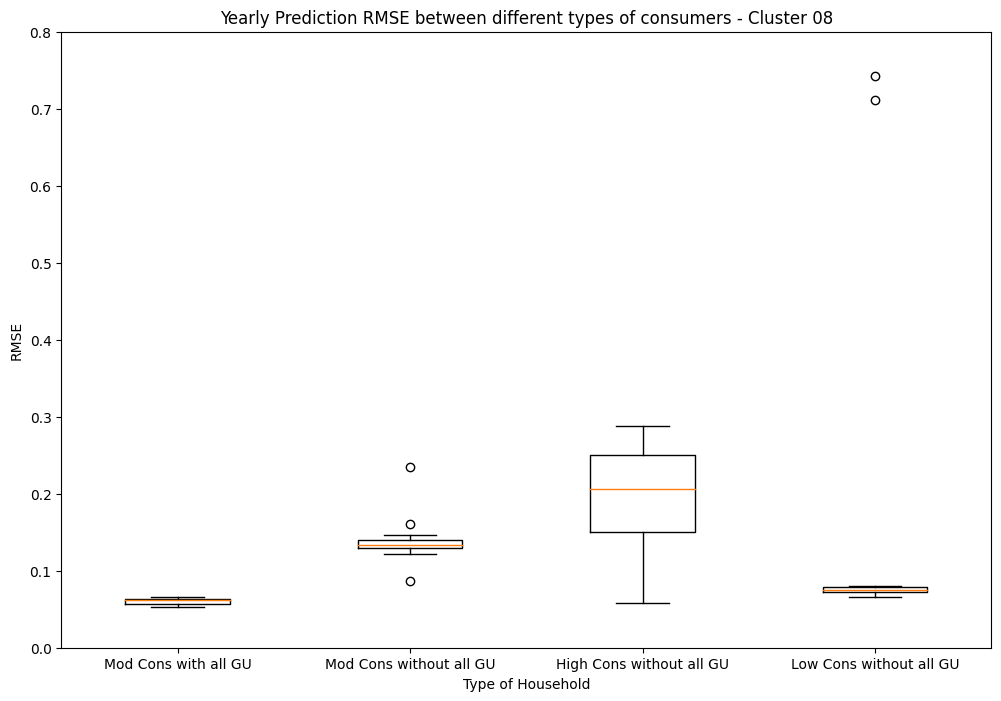

In [387]:
import matplotlib.pyplot as plt

# Data
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
client_moderate_all = [0.0636, 0.0633, 0.0623, 0.0544, 0.0570, 0.0621, 0.0638, 0.0662, 0.0528, 0.0611, 0.0539, 0.0650]
client_moderate_non_iid = [0.1465, 0.1213, 0.2346, 0.1320, 0.1612, 0.1316, 0.1329, 0.1345, 0.0866, 0.1222, 0.1383, 0.1357]
client_high_non_iid = [0.2507, 0.2581, 0.2875, 0.1531, 0.0866, 0.0583, 0.1690, 0.2217, 0.1417, 0.1896, 0.2505, 0.2484]
client_high_non_iid_2 = [0.0778, 0.0665, 0.0760, 0.0797, 0.0740, 0.0752, 0.7425, 0.7119, 0.0730, 0.0695, 0.0684, 0.0787]

# Creating the box plot
plt.figure(figsize=(12, 8))  # Adjust the figure size as per your preference
plt.boxplot([client_moderate_all, client_moderate_non_iid, client_high_non_iid, client_high_non_iid_2],
            labels=['Mod Cons with all GU', 'Mod Cons without all GU',
                    'High Cons without all GU', 'Low Cons without all GU'])

# Customizing the plot
plt.xlabel('Type of Household')
plt.ylabel('RMSE')
plt.title('Yearly Prediction RMSE between different types of consumers - Cluster 08')
plt.ylim(0, 0.8)

# Display the plot
plt.show()



In [ ]:
NUM_ROUNDS = 16
for round_num in range(1, NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data_13)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.054316048), ('loss', 0.010862483), ('num_examples', 811935), ('num_batches', 40600)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.05395219), ('loss', 0.010799821), ('num_examples', 811935), ('num_batches', 40600)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_absolute_error', 0.053744677), ('loss', 0.010755343), ('num_examples', 811935), ('num_batches', 40600)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finali

In [ ]:
evaluation_process2 = tff.learning.algorithms.build_fed_eval(model_fn)

In [ ]:
evaluation_state2 = evaluation_process2.initialize()
model_weights = training_process.get_model_weights(train_state)
evaluation_state2 = evaluation_process2.set_model_weights(evaluation_state2, model_weights)

In [ ]:
evaluation_output2_1 = evaluation_process2.next(evaluation_state2, federated_test_data1)
evaluation_output2_2 = evaluation_process2.next(evaluation_state2, federated_test_data2)
evaluation_output2_3 = evaluation_process2.next(evaluation_state2, federated_test_data3)
evaluation_output2_4 = evaluation_process2.next(evaluation_state2, federated_test_data4)
evaluation_output2_5 = evaluation_process2.next(evaluation_state2, federated_test_data5)
# evaluation_output2_6 = evaluation_process2.next(evaluation_state2, federated_test_data6)
# evaluation_output2_7 = evaluation_process2.next(evaluation_state2, federated_test_data7)

In [ ]:
loss_values_2 = []

# Append MAE values to the list
loss_values_2.append(evaluation_output2_1.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])
loss_values_2.append(evaluation_output2_2.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])
loss_values_2.append(evaluation_output2_3.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])
loss_values_2.append(evaluation_output2_4.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])
loss_values_2.append(evaluation_output2_5.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])
# loss_values_2.append(evaluation_output2_6.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])
# loss_values_2.append(evaluation_output2_7.metrics['client_work']['eval']['current_round_metrics']['mean_absolute_error'])

# Print the MAE values
print(loss_values_2)

[0.09900194, 0.03780721, 0.06357957, 0.03907571, 0.03658308]
